In [1]:
# Import TensorFlow
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_circles
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
print(tf.__version__) # find the version number (should be 2.x+)

2.8.2


In [2]:
# Go to Runtime > Change Runtime type > Accelerator Type > GPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Neural Network Classification with TensorFlow

Okay, we've seen how to deal with a regression problem in TensorFlow, let's look at how we can approach a classification problem.

A [classification problem](https://en.wikipedia.org/wiki/Statistical_classification) involves predicting whether something is one thing or another.

For example, you might want to:
* Predict whether or not someone has heart disease based on their health parameters. This is called **binary classification** since there are only two options.
* Decide whether a photo of is of food, a person or a dog. This is called **multi-class classification** since there are more than two options.
* Predict what categories should be assigned to a Wikipedia article. This is called **multi-label classification** since a single article could have more than one category assigned.

In this notebook, we're going to work through a number of different classification problems with TensorFlow. In other words, taking a set of inputs and predicting what class those set of inputs belong to.

## What we're going to cover

Specifically, we're going to go through doing the following with TensorFlow:
- Architecture of a classification model
- Input shapes and output shapes
  - `X`: features/data (inputs)
  - `y`: labels (outputs) 
    - "What class do the inputs belong to?"
- Creating custom data to view and fit
- Steps in modelling for binary and mutliclass classification
  - Creating a model
  - Compiling a model
    - Defining a loss function
    - Setting up an optimizer
      - Finding the best learning rate
    - Creating evaluation metrics
  - Fitting a model (getting it to find patterns in our data)
  - Improving a model
- The power of non-linearity
- Evaluating classification models
  - Visualizng the model ("visualize, visualize, visualize")
  - Looking at training curves
  - Compare predictions to ground truth (using our evaluation metrics)

## How you can use this notebook

You can read through the descriptions and the code (it should all run, except for the cells which error on purpose), but there's a better option.

Write all of the code yourself.

Yes. I'm serious. Create a new notebook, and rewrite each line by yourself. Investigate it, see if you can break it, why does it break?

You don't have to write the text descriptions but writing the code yourself is a great way to get hands-on experience.

Don't worry if you make mistakes, we all do. The way to get better and make less mistakes is to **write more code**.

## Typical architecture of a classification neural network 

The word *typical* is on purpose.

Because the architecture of a classification neural network can widely vary depending on the problem you're working on.

However, there are some fundamentals all deep neural networks contain:
* An input layer.
* Some hidden layers.
* An output layer.

Much of the rest is up to the data analyst creating the model.

The following are some standard values you'll often use in your classification neural networks.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| Input layer shape | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| Neurons per hidden layer | Problem specific, generally 10 to 100 | Same as binary classification |
| Output layer shape | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) | Same as binary classification |
| Output activation | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) | [Softmax](https://en.wikipedia.org/wiki/Softmax_function) |
| Loss function | [Cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`tf.keras.losses.BinaryCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) in TensorFlow) | Cross entropy ([`tf.keras.losses.CategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy) in TensorFlow) |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) | Same as binary classification |

***Table 1:*** *Typical architecture of a classification network.* ***Source:*** *Adapted from page 295 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

Don't worry if not much of the above makes sense right now, we'll get plenty of experience as we go through this notebook.

Let's start by importing TensorFlow as the common alias `tf`. For this notebook, make sure you're using version 2.x+.

# 1. Create Fake Classification Data

In [ ]:


# Make 1000 examples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, 
                    noise=0.03, 
                    random_state=42)

In [ ]:
X.shape

(1000, 2)

In [ ]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [ ]:
# Make dataframe of features and labels
circles = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


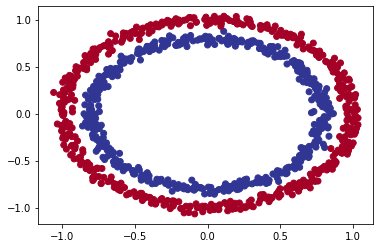

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

## The key piece: Non-linearity

Okay, so we saw our neural network can model straight lines (with ability a little bit better than guessing).

What about non-straight (non-linear) lines?

If we're going to model our classification data (the red and clue circles), we're going to need some non-linear lines.

> 🔨 **Practice:** Before we get to the next steps, I'd encourage you to play around with the [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true) (check out what the data has in common with our own classification data) for 10-minutes. In particular the tab which says "activation". Once you're done, come back.

Did you try out the activation options? If so, what did you find?

If you didn't, don't worry, let's see it in code.

We're going to replicate the neural network you can see at this link: [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).

![simple neural net created with TensorFlow playground](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-tensorflow-playground-simple-net-linear-activation.png)
*The neural network we're going to recreate with TensorFlow code. See it live at [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=1&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=1&seed=0.09561&showTestData=false&discretize=false&percTrainData=70&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&regularizationRate_hide=true&discretize_hide=true&regularization_hide=true&dataset_hide=true&noise_hide=true&batchSize_hide=true).*

The main change we'll add to models we've built before is the use of the `activation` keyword.


# 2. Split Train/Test


In [ ]:
X.shape

(1000, 2)

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Split it into training and test sets
X_train = X[:750]
X_test = X[750:]
y_train = y[:750]
y_test = y[750:]

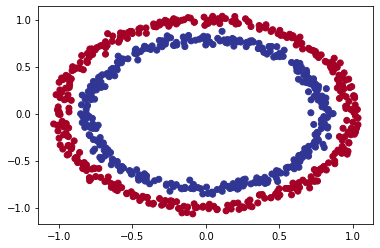

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu);

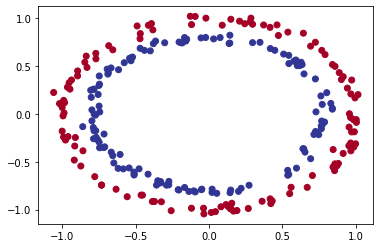

In [ ]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdYlBu);

# 3. Traininng the Network

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 1, 4 neurons, ReLU activation
  tf.keras.layers.Dense(4, activation=tf.keras.activations.relu), # hidden layer 2, 4 neurons, ReLU activation
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer must be a sigmoid for binary classification
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001), # Adam's default learning rate is 0.001
                metrics=['accuracy'])

# Fit the model
history = model_1.fit(X_train, y_train, epochs=200)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 2ms/step - loss: 0.6898 - accuracy: 0.5093
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5120
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6840 - accuracy: 0.5267
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5280
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6814 - accuracy: 0.5267
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6807 - accuracy: 0.5253
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6802 - accuracy: 0.5320
Epoch 8/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6797 - accuracy: 0.5360
Epoch 9/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6793 - accuracy: 0.5440
Epoch 10/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.5387
Epoch 11/200
24/24 [=

In [ ]:
def plot_decision_boundary(model, X, y, cmap=plt.cm.RdYlBu):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))
  
  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html
  
  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0]) > 1:
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(y_pred).reshape(xx.shape)
  
  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=cmap, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=cmap)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

doing binary classifcation...


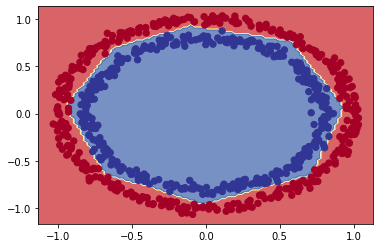

In [ ]:
# Check out the predictions our model is making 
plot_decision_boundary(model_1, X_train, y_train)

In [ ]:
model_1.evaluate(X_test, y_test)

8/8 [==============================] - 0s 2ms/step - loss: 0.0935 - accuracy: 0.9960


[0.09345769137144089, 0.9959999918937683]

In [ ]:
y_pred_1 = model_1.predict(X)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


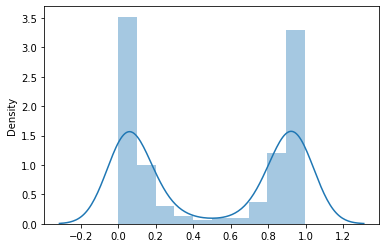

In [ ]:
sns.distplot(y_pred_1, bins=10)

In [ ]:
threshold = 0.5
y_pred_1_binary = np.where(y_pred_1 >= threshold, 1, 0)

In [ ]:
# Create binary predictions based on certainty of the output probability
y_pred_1_doubts = y_pred_1.ravel().copy()

# When p > 0.8, put the label 2
y_pred_1_doubts[y_pred_1_doubts >= 0.8 ] = 2

# When p < 0.2, put the label 0
y_pred_1_doubts[y_pred_1_doubts <= 0.2 ] = 0

# Elsewhere, put label 1 (as the "uncertain" label)
mask1 = 0.2 < y_pred_1_doubts
mask2 = y_pred_1_doubts < 0.8
y_pred_1_doubts[mask1 & mask2] = 1

In [ ]:
y_pred_1_doubts[:20]

array([2., 2., 2., 2., 0., 2., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 0.,
       2., 2., 0.], dtype=float32)

doing binary classifcation...


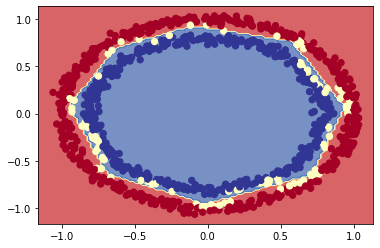

In [ ]:
# Check out the predictions our model is making 
plot_decision_boundary(model_1, X, y_pred_1_doubts)

# 4. Plot Loss Curves

Text(0.5, 1.0, 'Model_1 training curves')

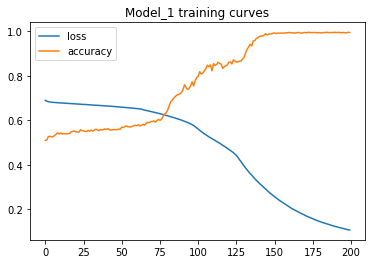

In [ ]:
# Plot the loss curves
pd.DataFrame(history.history).plot()
plt.title("Model_1 training curves")

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
len(history.history["accuracy"])

200

In [ ]:
history.history["accuracy"][:10]

[0.5093333125114441,
 0.5120000243186951,
 0.5266666412353516,
 0.527999997138977,
 0.5266666412353516,
 0.5253333449363708,
 0.5320000052452087,
 0.5360000133514404,
 0.5440000295639038,
 0.5386666655540466]

# 5. The importance of the learning rate

Aside from the architecture itself (the layers, number of neurons, activations, etc), the most important hyperparameter you can tune for your neural network models is the **learning rate**.

In `model_1` you saw we lowered the Adam optimizer's learning rate from the default of `0.001` (default) to `0.01`.

And you might be wondering why we did this.

Put it this way, it was a lucky guess.

I just decided to try a lower learning rate and see how the model went.

Now you might be thinking, "Seriously? You can do that?"

And the answer is yes. You can change any of the hyperparamaters of your neural networks.

With practice, you'll start to see what kind of hyperparameters work and what don't.

That's an important thing to understand about machine learning and deep learning in general. It's very experimental. You build a model and evaluate it, build a model and evaluate it.

That being said, I want to introduce you a trick which will help you find the optimal learning rate (at least to begin training with) for your models going forward.

To do so, we're going to use the following:
* A [learning rate **callback**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler).
   * You can think of a callback as an extra piece of functionality you can add to your model *while* its training.
* Another model (we could use the same ones as above, we we're practicing building models here).
* A modified loss curves plot.

We'll go through each with code, then explain what's going on.

> 🔑 **Note:** The default hyperparameters of many neural network building blocks in TensorFlow are setup in a way which usually work right out of the box (e.g. the [Adam optimizer's](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) default settings can usually get good results on many datasets). So it's a good idea to try the defaults first, then adjust as needed.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model (same as model_8)
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy", # we can use strings here too
              optimizer="Adam", # same as tf.keras.optimizers.Adam() with default settings
              metrics=["accuracy"]) 

# Create a learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20)) # traverse a set of learning rate values starting from 1e-4, increasing by 10**(epoch/20) every epoch

# Fit the model (passing the lr_scheduler callback)
history_2 = model_2.fit(X_train, 
                      y_train, 
                      epochs=100,
                      callbacks=[lr_scheduler])

Epoch 1/100
24/24 [==============================] - 1s 2ms/step - loss: 0.6909 - accuracy: 0.5080 - lr: 1.0000e-04
Epoch 2/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6905 - accuracy: 0.5067 - lr: 1.1220e-04
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6899 - accuracy: 0.5067 - lr: 1.2589e-04
Epoch 4/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5053 - lr: 1.4125e-04
Epoch 5/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6888 - accuracy: 0.5080 - lr: 1.5849e-04
Epoch 6/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.5133 - lr: 1.7783e-04
Epoch 7/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6875 - accuracy: 0.5093 - lr: 1.9953e-04
Epoch 8/100
24/24 [==============================] - 0s 2ms/step - loss: 0.6868 - accuracy: 0.5040 - lr: 2.2387e-04
Epoch 9/100
24/24 [==============================] - 0s 2ms/step - loss:

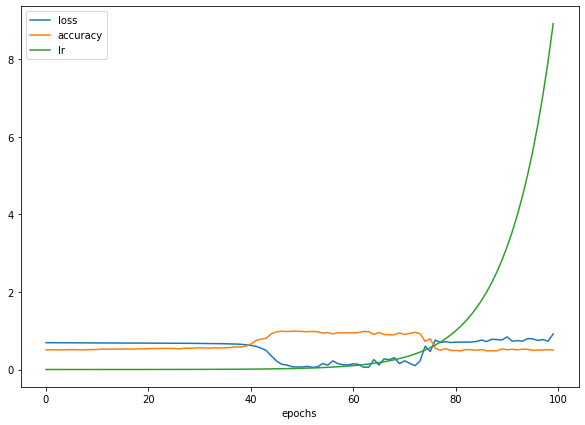

In [ ]:
# Checkout the history
pd.DataFrame(history_2.history).plot(figsize=(10,7), xlabel="epochs");

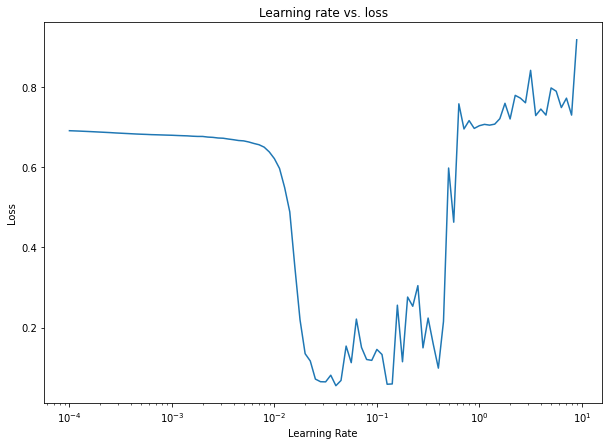

In [ ]:
# Plot the learning rate versus the loss
lrs = 1e-4 * (10 ** (np.arange(100)/20))
plt.figure(figsize=(10, 7))
plt.semilogx(lrs, history.history["loss"]) # we want the x-axis (learning rate) to be log scale
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning rate vs. loss");

To figure out the ideal value of the learning rate (at least the ideal value to *begin* training our model), the rule of thumb is to take the learning rate value where the loss is still decreasing but not quite flattened out (usually about 10x smaller than the bottom of the curve).

In this case, our ideal learning rate ends up between `0.01` ($10^{-2}$) and `0.02`.

![finding the ideal learning rate by plotting learning rate vs. loss](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/02-learning-rate-vs-loss.png)

*The ideal learning rate at the start of model training is somewhere just before the loss curve bottoms out (a value where the loss is still decreasing).*

In [ ]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(4, activation="relu"),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model with the ideal learning rate
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.02), # to adjust the learning rate, you need to use tf.keras.optimizers.Adam (not "adam")
                metrics=["accuracy"])

# Fit the model for 20 epochs (5 less than before)
history_3 = model_3.fit(X_train, y_train, epochs=20)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5493
Epoch 2/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6767 - accuracy: 0.5613
Epoch 3/20
24/24 [==============================] - 0s 2ms/step - loss: 0.6642 - accuracy: 0.5787
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.5840
Epoch 5/20
24/24 [==============================] - 0s 2ms/step - loss: 0.6417 - accuracy: 0.6160
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5966 - accuracy: 0.6880
Epoch 7/20
24/24 [==============================] - 0s 3ms/step - loss: 0.5323 - accuracy: 0.7667
Epoch 8/20
24/24 [==============================] - 0s 3ms/step - loss: 0.4819 - accuracy: 0.8107
Epoch 9/20
24/24 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.8680
Epoch 10/20
24/24 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.9520
Epoch 11/20
24/24 [===========

In [ ]:
# Evaluate model on the test dataset
model_3.evaluate(X_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.0350 - accuracy: 0.9960


[0.03499864786863327, 0.9959999918937683]

doing binary classifcation...
doing binary classifcation...


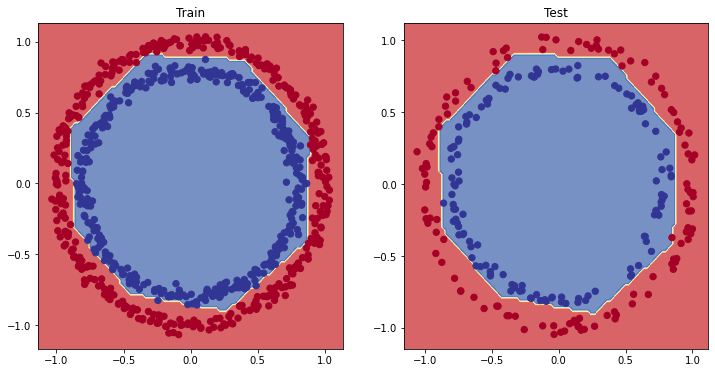

In [ ]:
# Plot the decision boundaries for the training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X=X_test, y=y_test)
plt.show()

In [ ]:
# Create a confusion matrix
y_preds = model_3.predict(X_test)
confusion_matrix(y_test, tf.round(y_preds))

array([[118,   1],
       [  0, 131]])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


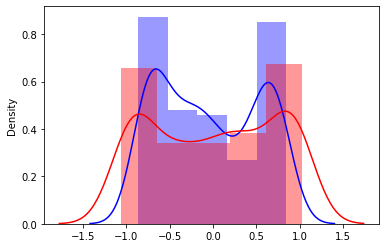

In [ ]:
# Which label corresponds to each color
sns.distplot(X_test[y_test == 1], color='blue')
sns.distplot(X_test[y_test == 0], color='red')

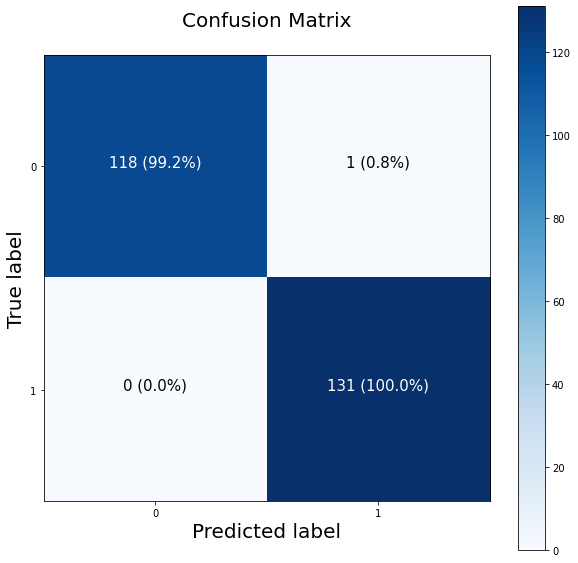

In [ ]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(y_test, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
           horizontalalignment="center",
           color="white" if cm[i, j] > threshold else "black",
           size=15)

In [ ]:
y_preds_binary = np.round(y_preds).ravel()
y_test != y_preds_binary

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [ ]:
np.where(y_test != y_preds_binary)

(array([239]),)

In [ ]:
X_test[239]

array([ 0.84734275, -0.37199056])

In [ ]:
y_preds_binary_error = y_preds_binary.copy()
y_preds_binary_error[y_preds_binary_error>0] = 2
y_preds_binary_error[239] = 1

doing binary classifcation...


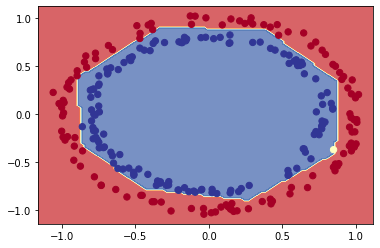

In [ ]:
# Check out the wrong prediction
plot_decision_boundary(model_3, X_test, y_preds_binary_error)